In [7]:
import torch
import torch.optim as optim
from models.DiffLoad.diffusion.layers import CondModel_v2
from matplotlib import pyplot as plt
from utils.helper import make_beta_schedule, EMA, ObjectView
from utils.plots import hdr_plot_style
# hdr_plot_style()
from tqdm import tqdm
from models.DiffLoad.ddpm import DDPM1d
from utils.config import config_dataset_london, config_ddpm, config_nn_london

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [9]:
configs = {
    'epoch': 50000,
    'batch_size': 3000,
    'learning_rate': 5e-4,
    'lr_decay': 0.99,
    'lr_decay_step': 200,
    'mode': None, # ["checkpoint", None]
    'use_MLP':True,
    'use_solar':False
}
configs.update(config_dataset_london)
configs.update(config_ddpm)
configs.update(config_nn_london)
args = ObjectView(configs)
args.save_name = "diff_phy" if args.use_solar else "diff_base"
print(args.save_name)

diff_base


# Dataset

In [10]:
X_train = torch.load("../data/london/tensor_small/y_tr.pt", weights_only=True)
X_test = torch.load("../data/london/tensor_small/y_val.pt", weights_only=True)
cond_train = torch.load("../data/london/tensor_small/X_tr.pt", weights_only=True)
cond_test = torch.load("../data/london/tensor_small/X_val.pt", weights_only=True)

In [11]:
print(X_train.shape)

torch.Size([16696, 48])


In [12]:
# Select betas
n_steps = args.n_steps

betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=args.beta_start, end=args.beta_end)
betas = betas.to(device)
model = CondModel_v2(args)
if args.mode == "checkpoint":
    checkpoint = torch.load('../result/models/pecan/{}.pth'.format(args.save_name))
    model = checkpoint['ddpm'].model
    args.learning_rate = args.learning_rate * args.lr_decay ** (args.epoch/args.lr_decay_step)

# print(args.learning_rate)
model = model.to(device)
X_train = X_train.to(device)
cond_train = cond_train.to(device)
# PV_base_train = PV_base_train.to(device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_decay_step, gamma=args.lr_decay)
ddpm = DDPM1d(model, betas, n_steps, (args.input_dim,), loss_type='l2')
# Create EMA model
ema = EMA(args.ema_decay)
ema.register(model)

Loss = []
for j in tqdm(range(args.epoch)):
    # X is a torch Variable
    loss_a = 0
    permutation = torch.randperm(X_train.size()[0])
    for i in range(0, X_train.size()[0], args.batch_size):
        # Retrieve current batch 
        indices = permutation[i:i+args.batch_size]
        batch_x = X_train[indices]
        batch_x = batch_x + 0.05 * torch.randn_like(batch_x)
        batch_cond = cond_train[indices]
        # Compute the loss.
        loss = ddpm(batch_x, batch_cond)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # 
        loss_a = loss_a + loss.item()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        scheduler.step()
        # Update the exponential moving average
        ema.update(model)
        ddpm.model = model
    
    loss_a = loss_a / X_train.size()[0] * args.batch_size
    if (j+1) % 100 == 0:
        Loss.append(loss_a)
    if (j+1) % 1000 == 0:
        print("loss: ", loss_a)
    if (j+1) % 10000 == 0 or (j+1) == args.epoch:
        checkpoint = {
            'config': configs,
            'ddpm': ddpm,
            'Loss': Loss
        }
        torch.save(checkpoint, f"../result/models/london/{args.save_name}_{j+1}.pth")

/home/cybsbbbb/anaconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  2%|▏         | 1000/50000 [13:35<11:05:50,  1.23it/s]

loss:  0.049797300415342936


  4%|▍         | 2000/50000 [27:10<10:57:50,  1.22it/s]

loss:  0.04859083047860481


  6%|▌         | 3000/50000 [40:46<10:38:29,  1.23it/s]

loss:  0.048334968901517346


  8%|▊         | 4000/50000 [54:20<10:25:12,  1.23it/s]

loss:  0.04582081229265763


 10%|█         | 5000/50000 [1:07:55<10:09:03,  1.23it/s]

loss:  0.04472427501217795


 12%|█▏        | 6000/50000 [1:21:30<9:57:56,  1.23it/s] 

loss:  0.04426923914708529


 14%|█▍        | 7000/50000 [1:35:05<9:44:10,  1.23it/s] 

loss:  0.045065839239853564


 16%|█▌        | 8000/50000 [1:48:40<9:29:37,  1.23it/s]

loss:  0.0433390500460393


 18%|█▊        | 9000/50000 [2:02:15<9:16:43,  1.23it/s]

loss:  0.04316043290771476


 20%|██        | 10000/50000 [2:15:50<9:19:32,  1.19it/s]

loss:  0.042643626526205174


 22%|██▏       | 11000/50000 [2:29:25<8:49:08,  1.23it/s]

loss:  0.042132212622889964


 24%|██▍       | 12000/50000 [2:43:00<8:34:18,  1.23it/s]

loss:  0.04197676118532893


 26%|██▌       | 13000/50000 [2:56:35<8:21:47,  1.23it/s]

loss:  0.04418999930396569


 28%|██▊       | 14000/50000 [3:10:10<8:08:40,  1.23it/s]

loss:  0.04203056481055055


 30%|███       | 15000/50000 [3:23:45<7:55:02,  1.23it/s]

loss:  0.04214002154178464


 32%|███▏      | 16000/50000 [3:37:19<7:41:33,  1.23it/s]

loss:  0.04548434401042563


 34%|███▍      | 17000/50000 [3:50:54<7:26:53,  1.23it/s]

loss:  0.04465907328384141


 36%|███▌      | 18000/50000 [4:04:29<7:14:54,  1.23it/s]

loss:  0.04270106819996036


 38%|███▊      | 19000/50000 [4:18:04<7:02:04,  1.22it/s]

loss:  0.04304802758332697


 40%|████      | 20000/50000 [4:31:39<6:59:56,  1.19it/s]

loss:  0.04384901274618602


 42%|████▏     | 21000/50000 [4:45:14<6:34:11,  1.23it/s]

loss:  0.03932196571958882


 44%|████▍     | 22000/50000 [4:58:48<6:20:52,  1.23it/s]

loss:  0.0433284752731353


 46%|████▌     | 23000/50000 [5:12:23<6:06:55,  1.23it/s]

loss:  0.04213113559987423


 48%|████▊     | 24000/50000 [5:25:58<5:52:45,  1.23it/s]

loss:  0.041645742947468645


 50%|█████     | 25000/50000 [5:39:33<5:39:17,  1.23it/s]

loss:  0.04392981691670635


 52%|█████▏    | 26000/50000 [5:53:08<5:24:59,  1.23it/s]

loss:  0.04326179958290898


 54%|█████▍    | 27000/50000 [6:06:42<5:11:15,  1.23it/s]

loss:  0.040475061769312974


 56%|█████▌    | 28000/50000 [6:20:17<4:58:44,  1.23it/s]

loss:  0.041337368298530804


 58%|█████▊    | 29000/50000 [6:33:52<4:44:49,  1.23it/s]

loss:  0.04297416348404786


 60%|██████    | 30000/50000 [6:47:28<4:40:24,  1.19it/s]

loss:  0.04240305613231933


 62%|██████▏   | 31000/50000 [7:01:02<4:17:14,  1.23it/s]

loss:  0.04378494627641672


 64%|██████▍   | 32000/50000 [7:14:37<4:03:40,  1.23it/s]

loss:  0.043730350781569484


 66%|██████▌   | 33000/50000 [7:28:12<3:50:59,  1.23it/s]

loss:  0.041266349039411336


 68%|██████▊   | 34000/50000 [7:41:47<3:36:39,  1.23it/s]

loss:  0.042160694493194144


 70%|███████   | 35000/50000 [7:55:21<3:23:48,  1.23it/s]

loss:  0.04500039051245375


 72%|███████▏  | 36000/50000 [8:08:56<3:09:35,  1.23it/s]

loss:  0.04205971940188072


 74%|███████▍  | 37000/50000 [8:22:32<2:57:07,  1.22it/s]

loss:  0.043187136250888554


 76%|███████▌  | 38000/50000 [8:36:06<2:42:40,  1.23it/s]

loss:  0.04266762492841776


 78%|███████▊  | 39000/50000 [8:49:41<2:29:12,  1.23it/s]

loss:  0.04090731146878813


 80%|████████  | 40000/50000 [9:03:16<2:20:06,  1.19it/s]

loss:  0.042813860422609866


 82%|████████▏ | 41000/50000 [9:16:51<2:02:32,  1.22it/s]

loss:  0.04180076263869957


 84%|████████▍ | 42000/50000 [9:30:26<1:48:32,  1.23it/s]

loss:  0.03941387346859577


 86%|████████▌ | 43000/50000 [9:44:01<1:35:00,  1.23it/s]

loss:  0.042852906355831576


 88%|████████▊ | 44000/50000 [9:57:36<1:21:35,  1.23it/s]

loss:  0.04284204910703407


 90%|█████████ | 45000/50000 [10:11:11<1:08:05,  1.22it/s]

loss:  0.043660485523493595


 92%|█████████▏| 46000/50000 [10:24:46<54:15,  1.23it/s]  

loss:  0.04327817381349373


 94%|█████████▍| 47000/50000 [10:38:20<40:43,  1.23it/s]

loss:  0.04150221774923099


 96%|█████████▌| 48000/50000 [10:51:55<27:08,  1.23it/s]

loss:  0.042627190043823995


 98%|█████████▊| 49000/50000 [11:05:30<13:32,  1.23it/s]

loss:  0.041901346815506356


100%|██████████| 50000/50000 [11:19:05<00:00,  1.23it/s]

loss:  0.04218757187364829


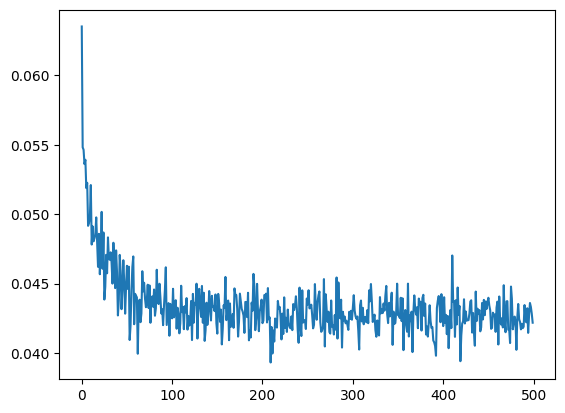

In [13]:
plt.plot(Loss)

In [14]:
# cond_test = cond_test.to(device)
# # PV_base_test = PV_base_test.to(device)
# X_test_hat = ddpm.sample_seq(batch_size=len(cond_test), cond=cond_test)[-1]
# X_test_hat = X_test_hat.to("cpu")
# X_test_hat = X_test_hat.reshape(args.num_class, -1, 96)
# X_test = X_test.reshape(args.num_class, -1, 96)
# for j in range(config_dataset_london["num_class"])[:10]:
#     plt.figure(figsize=(36,6), dpi=300)
#     plt.subplot(1,4,1)
#     for i in range(len(X_test[j])):
#         plt.plot(X_test[j][i])
#     plt.title("actual data")
#     plt.subplot(1,4,2)
#     for i in range(len(X_test_hat[j])):
#         plt.plot(X_test_hat[j][i])
#     plt.title("generated load profile (MLP0_Solar0)")
# 
#     plt.subplot(1,4,3)
#     plt.plot(X_test_hat[j].mean(dim=0), label = "mean of generated data")
#     plt.plot(X_test[j].mean(dim=0), label = "mean of actual data")
#     plt.legend(fontsize=10)
#     plt.subplot(1,4,4)
#     plt.plot(X_test_hat[j].var(dim=0), label = "var of generated data")
#     plt.plot(X_test[j].var(dim=0), label = "var of actual data")
#     plt.legend(fontsize=10)
#     plt.tight_layout()


In [19]:
import torch
from utils.config import config_dataset_london
from tqdm import tqdm

X_train = torch.load("../data/london/tensor_small/y_tr.pt", weights_only=True)
X_test = torch.load("../data/london/tensor_small/y_val.pt", weights_only=True)
cond_train = torch.load("../data/london/tensor_small/X_tr.pt", weights_only=True)
cond_test = torch.load("../data/london/tensor_small/X_val.pt", weights_only=True)

def get_x_hat(checkpoint, cond, PV_base = None):
    ddpm = checkpoint['ddpm']
    device = ddpm.device
    cond = cond.to(device)
    if PV_base is not None:
        PV_base = PV_base.to(device)
    X_test_hat = ddpm.sample_seq(batch_size=len(cond), cond=cond, PV_base = PV_base)[-1]
    return X_test_hat.to("cpu")

model1 = "diff_base_50000"
checkpoint1 = torch.load('../result/models/london/{}.pth'.format(model1))

X_test_hat_diffusion_base = []
cond = cond_test
for i in tqdm(range(20)):
    X_test_hat1 = get_x_hat(checkpoint1, cond)
    X_test_hat_diffusion_base.append(X_test_hat1)

X_test_hat_diffusion_base = torch.stack(X_test_hat_diffusion_base)
X_test_hat_diffusion_base = X_test_hat_diffusion_base.permute(1, 0, 2)
print(X_test_hat_diffusion_base.shape)

torch.save(X_test_hat_diffusion_base, "../result/data/london/load_hat_diff_base.pt")

/tmp/ipykernel_50717/2768338713.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint1 = torch.load('../result/models/london/{}.pth'.format(model1))
100%|█████████

torch.Size([4174, 20, 48])


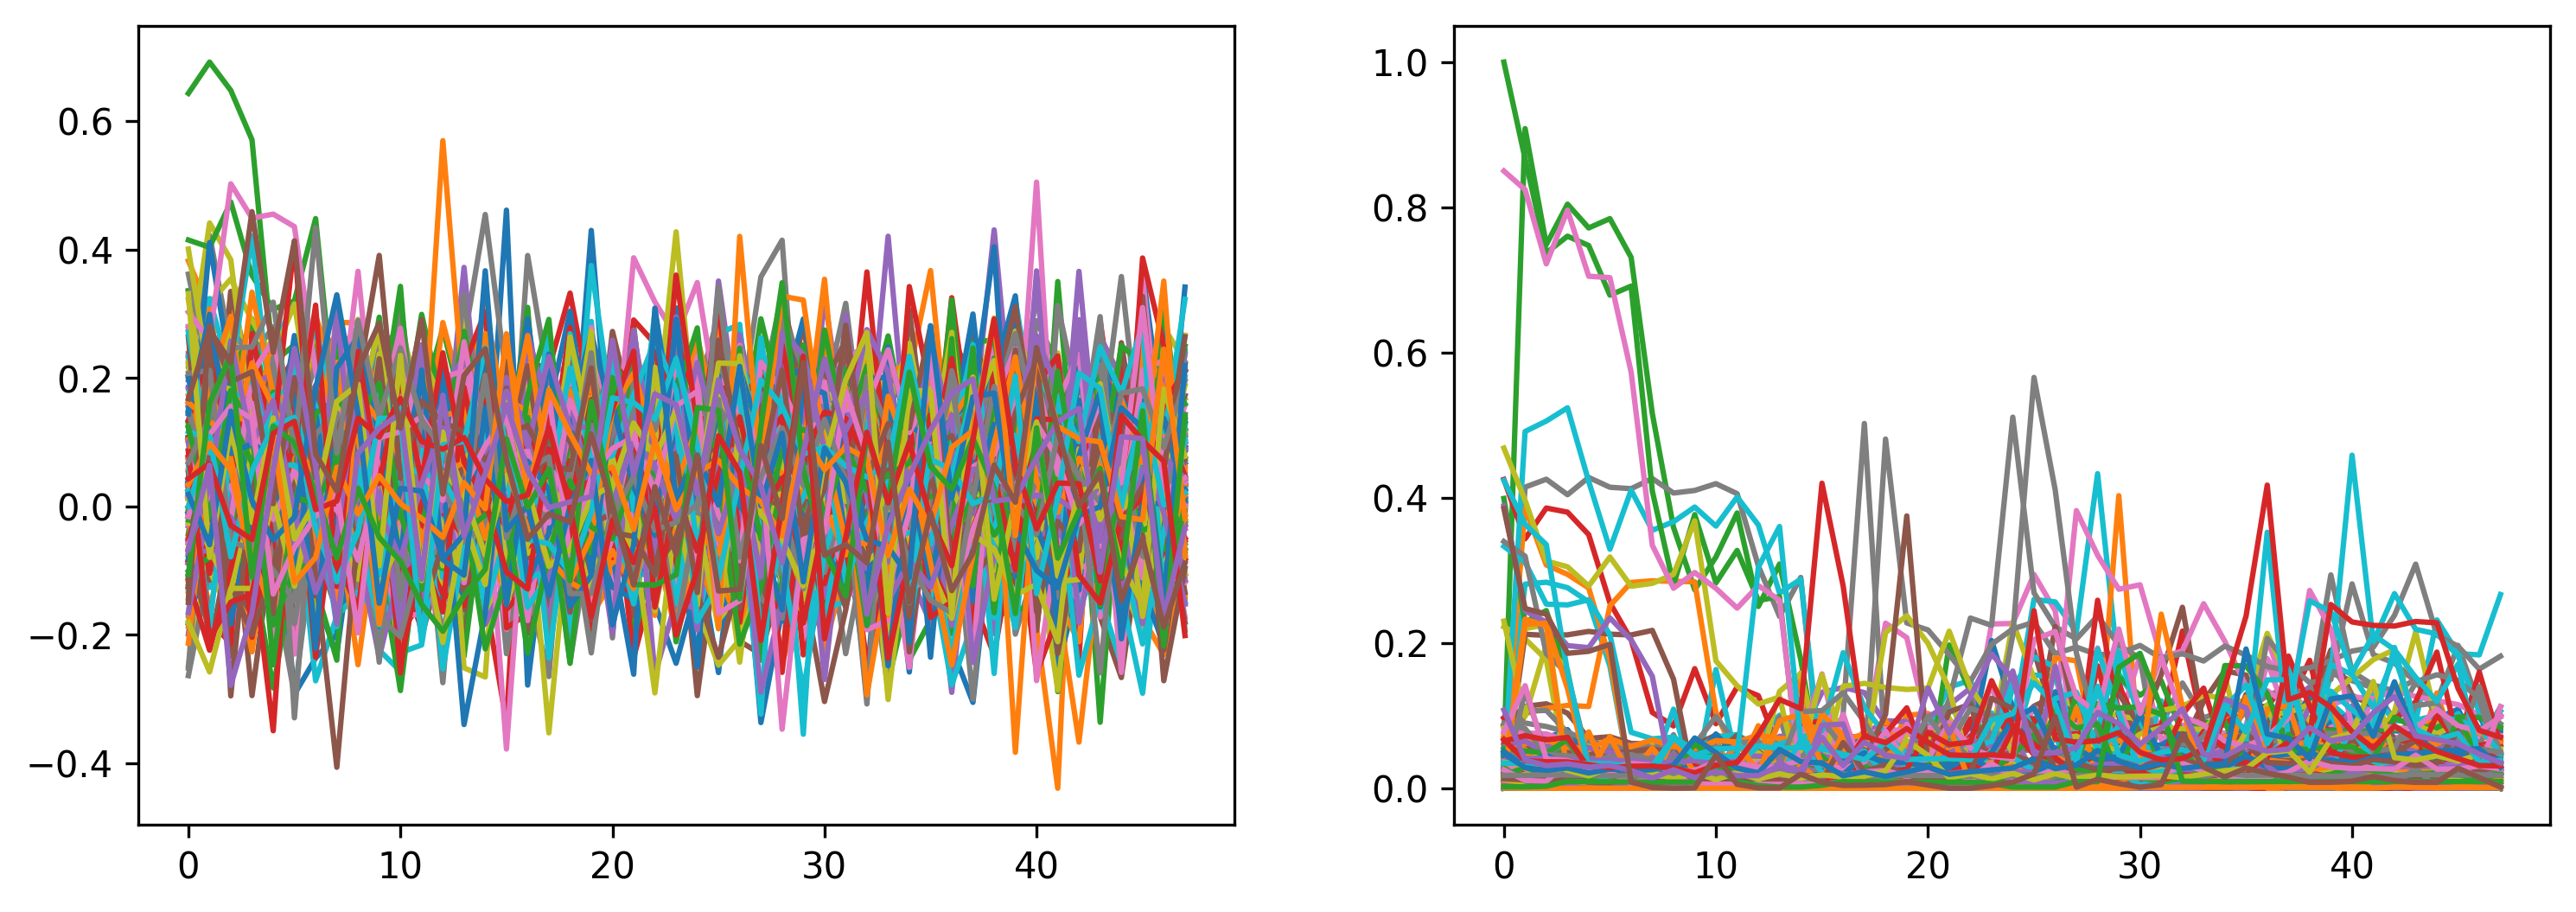

In [20]:
user = 0
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(1,2,1)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test_hat_diffusion_base[i, 0, :])
plt.subplot(1,2,2)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test[i])